In [112]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix

ohe = pd.read_csv('data/ohe.csv')
to_drop_feats = ['district','gps','water','wpt','public','ward','permit','subvillage','recorded']
to_drop_cols = []
for col in ohe.columns:
    if col.split('_')[0] in to_drop_feats: to_drop_cols.append(col)
ohe.drop(to_drop_cols,axis=1,inplace=True)
target = pd.read_csv('data/labels.csv')['translate']
ohe.head()

,amount_tsh,population,funder_Adb,funder_Adra,funder_Amref,funder_Ces(gmbh),funder_Danida,funder_Ded,funder_Dh,funder_Dhv,...,source_shallow well,source_spring,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other,year_since_construct
0,6000.0,109,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,12
1,0.0,280,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,3
2,25.0,250,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,4
3,0.0,58,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,27
4,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,11


X_train,X_test,y_train,y_test = train_test_split(ohe,target,test_size = .75,random_state=13)

model = xgb.XGBClassifier()
model.fit(X_train,y_train)
y_hat_test = model.predict(X_test)
accuracy_score(y_test,y_hat_test)

- Baseline accuracy for xgb: 74% (small train size, for computation time)
- Accuracy artificially inflated because of underpredicting category 1
- Need to resample, start with undersampling: accuracy 67%
- Hyperparameters-gridsearch
- try other methods: random forest, knn (might be too intensive for knn)

In [89]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=13)
X_resampled, y_resampled = rus.fit_resample(ohe, target)

X_train,X_test,y_train,y_test = train_test_split(X_resampled, y_resampled,test_size = .25,random_state=13)
y_resampled.value_counts()

2    4317
1    4317
0    4317
Name: translate, dtype: int64

In [113]:
X_train,X_test,y_train,y_test = train_test_split(X_resampled, y_resampled,test_size = .25,random_state=13)

clf = xgb.XGBClassifier()
clf.fit(X_train,y_train)
y_xgb_test = clf.predict(X_test)
accuracy_score(y_test,y_xgb_test)

0.6695491043854231

### Questions
- where are the ones in need of repairs/replacing? Make predictions, make a map
- What physical features have greatest impact? IE water quality, altitude, water source
- What controlled features have greatest impact? IE funder, installer, payment type
- What impact do features have on other features? IE does funder affect payment type, or installer affect water source?

[[37.6  12.45  4.26]
 [ 1.62  5.04  0.6 ]
 [ 9.13  6.24 23.05]]


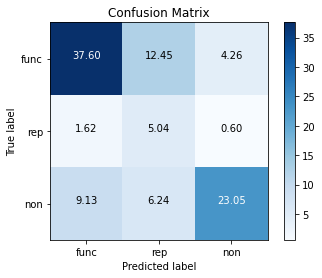

In [13]:
from cf_matrix_plot import plot_confusion_matrix
cnf = confusion_matrix(target,y_hat_all)
plot_confusion_matrix(cnf,['func','rep','non'],normalize=True)

In [33]:
from sklearn.tree import DecisionTreeClassifier 
dtc = DecisionTreeClassifier()
dtc.fit(X_train,y_train)
y_hat_all = dtc.predict(ohe)
accuracy_score(target,y_hat_all)

0.691060606060606

In [61]:
bag = {}
for col in ohe.columns:
    frst_word = col.split('_')[0]
    if frst_word not in bag.keys(): bag[frst_word]=[]
    bag[frst_word].append(col)

In [53]:
accs = []
accs_train = []
accs_test = []
for feature in bag.keys():
    lst = bag[feature]
    rf = RandomForestClassifier()
    rf.fit(X_train[lst],y_train)
    y_hat_all = rf.predict(ohe[lst])
    acc = accuracy_score(target,y_hat_all)
    accs.append(acc)
    y_hat_train = rf.predict(X_train[lst])
    acc_tr = accuracy_score(y_train,y_hat_train)
    accs_train.append(acc_tr)
    y_hat_test = rf.predict(X_test[lst])
    acc_ts = accuracy_score(y_test,y_hat_test)
    accs_test.append(acc_ts)

In [62]:
lens = [len(x) for x in list(bag.values())]
important = pd.DataFrame([list(bag.keys()),accs,accs_train,accs_test,lens]).transpose()
important.columns = ['feature','accuracy','train accuracy','test accuracy','x']
important.sort_values('test accuracy',ascending=False)

,feature,accuracy,train accuracy,test accuracy,x
12,lga,0.466633,0.536909,0.528413,125
20,quantity,0.507205,0.455266,0.481779,4
16,extraction,0.386263,0.462782,0.473132,13
10,region,0.404916,0.461855,0.46572,21
5,funder,0.514158,0.439102,0.447807,44
21,source,0.442626,0.432204,0.438851,9
22,waterpoint,0.582508,0.428807,0.433601,7
8,basin,0.426364,0.413466,0.425571,9
6,installer,0.334933,0.415526,0.424027,39
2,population,0.336515,0.437867,0.42341,1


In [ ]:
to_drop = ['district','gps','water','wpt','public','ward','permit','subvillage','recorded']

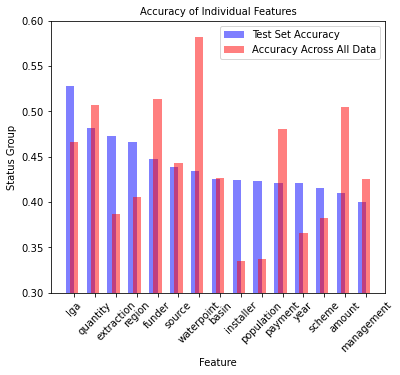

In [108]:
plt.figure(figsize=(6,5))
temp = important.sort_values('test accuracy',ascending=False)[:15]
plt.bar(temp['feature'],temp['test accuracy'],color='blue',alpha=.5,align='edge',width=-.4,label='Test Set Accuracy')
plt.bar(temp['feature'],temp['accuracy'],color='red',alpha=.5,width=.4,label='Accuracy Across All Data')
font = {'size': 10}
plt.title('Accuracy of Individual Features',font)
plt.xlabel('Feature',fontdict=font)
plt.ylabel('Status Group',font)
plt.ylim([.3,.6])
plt.xticks(rotation=45)
plt.legend()

Keep best 15 features, drop rest

In [114]:
from sklearn.ensemble import RandomForestClassifier 
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_rf_test = rf.predict(X_test)
accuracy_score(y_test,y_rf_test)

0.6945645460160593

In [91]:
y_hat_train = rf.predict(X_train)
accuracy_score(y_train,y_hat_train)

0.9331823329558324

In [49]:
#cnf1 = confusion_matrix(target,rf.predict(ohe))
right = 0
cm = cnf1-cnf2
total = sum(sum(cm))
for diag in range(len(cm)):
    right += cm[diag,diag]
print(right/total)

0.6809024493328235


[[714 223 160]
 [199 787 113]
 [178 116 748]]


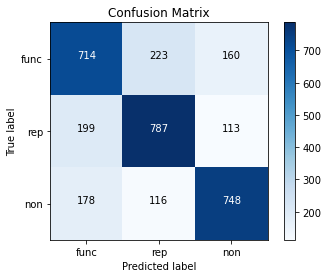

In [115]:
from cf_matrix_plot import plot_confusion_matrix
cnf1 = confusion_matrix(y_test,y_rf_test)
# cnf2 = confusion_matrix(y_train,rf.predict(X_train))
plot_confusion_matrix(cnf1,['func','rep','non'])

[[18619  6366  4054]
 [  198   784   117]
 [ 3136  2367 14046]]


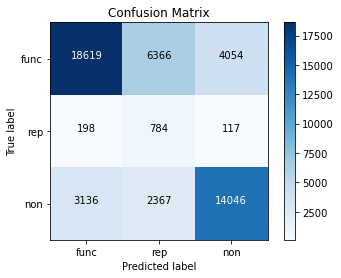

In [93]:
from cf_matrix_plot import plot_confusion_matrix
cnf1 = confusion_matrix(target,rf.predict(ohe))
cnf2 = confusion_matrix(y_train,rf.predict(X_train))
plot_confusion_matrix(cnf1-cnf2,['func','rep','non'])